In [ ]:
import os
import cv2
import numpy as np
import string
import time
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

import tensorflow.keras.backend as K
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.layers import Dense, Reshape, BatchNormalization, Input, Conv2D, MaxPool2D, Lambda, Bidirectional

from tensorflow.compat.v1.keras.layers import CuDNNLSTM ,LSTM
from tensorflow.keras.models import Model
from tensorflow.keras.activations import relu, sigmoid, softmax

from tensorflow.keras.utils import to_categorical, Sequence
from tensorflow.keras.callbacks import ModelCheckpoint
from tqdm import tqdm
from collections import Counter

from PIL import Image

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!wget https://github.com/rajesh-bhat/spark-ai-summit-2020-text-extraction/blob/master/mjsynth_sample.zip

In [ ]:
!unzip -qq /content/drive/MyDrive/bach/mjsynth_sample.zip

In [ ]:
!unzip -qq /content/drive/MyDrive/bach/mjsnew2zip.zip

In [ ]:
!unzip -qq /content/drive/MyDrive/bach/mjslastzip.zip

In [ ]:
!unzip -qq /content/drive/MyDrive/bach/mjlast2zip.zip

In [ ]:
!unzip -qq /content/drive/MyDrive/bach/3mjsynth_sent.zip

In [ ]:
import os

final_paths = []
final_texts = []

data_folders = ["mjsynth_sample"]

for folder in data_folders:
    data_folder = folder
    for path in os.listdir(data_folder):
        final_paths.append(data_folder + "/" + path)
        final_texts.append(path.split("_")[1])


In [ ]:
final_paths[:10], final_texts[:10]

(['mjsynth_sample/112_TRAITS_80097.jpg',
  'mjsynth_sample/1_RELENTS_64371.jpg',
  'mjsynth_sample/417_CLAMORED_13877.jpg',
  'mjsynth_sample/163_ORTHODOXY_53820.jpg',
  'mjsynth_sample/181_despairingly_21050.jpg',
  'mjsynth_sample/82_Lightships_44464.jpg',
  'mjsynth_sample/310_DIETITIAN_21553.jpg',
  'mjsynth_sample/46_Misguidedly_48917.jpg',
  'mjsynth_sample/156_bloopers_8195.jpg',
  'mjsynth_sample/371_Coriolis_17023.jpg'],
 ['TRAITS',
  'RELENTS',
  'CLAMORED',
  'ORTHODOXY',
  'despairingly',
  'Lightships',
  'DIETITIAN',
  'Misguidedly',
  'bloopers',
  'Coriolis'])

In [ ]:
vocab = set("".join(map(str, final_texts)))
print(sorted(vocab))

[' ', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


In [ ]:
Counter("".join(map(str, final_texts)))

Counter({'T': 10070,
         'R': 11125,
         'A': 12188,
         'I': 12698,
         'S': 14094,
         'E': 16731,
         'L': 7997,
         'N': 10222,
         'C': 7202,
         'M': 4747,
         'O': 8783,
         'D': 6379,
         'H': 3898,
         'X': 428,
         'Y': 2290,
         'd': 9730,
         'e': 31940,
         's': 23114,
         'p': 6906,
         'a': 21620,
         'i': 24248,
         'r': 19958,
         'n': 20243,
         'g': 8371,
         'l': 14694,
         'y': 4644,
         'h': 6098,
         't': 18283,
         'u': 9213,
         'b': 4718,
         'o': 17332,
         'c': 10014,
         'P': 5178,
         'k': 2761,
         'G': 4768,
         'm': 6933,
         'f': 3274,
         'B': 3874,
         'V': 1787,
         'F': 2799,
         'w': 2238,
         'v': 2718,
         'Z': 696,
         'U': 4990,
         'K': 1611,
         'W': 1806,
         'q': 439,
         'j': 453,
         'x': 818,
        

In [ ]:
char_list = sorted(vocab)

def encode_to_labels(txt):
    # encoding each output word into digits
    dig_lst = []

    for index, char in enumerate(txt):
        try:
            dig_lst.append(char_list.index(char))
        except:
            print(char)

    return dig_lst

In [ ]:
encode_to_labels("HELLO my")

[18, 15, 22, 22, 25, 0, 49, 61]

In [ ]:
from sklearn.model_selection import train_test_split

# Assuming final_paths and final_texts are your lists of paths and texts

train_paths, valid_paths, train_texts, valid_texts = train_test_split(final_paths, final_texts, test_size=0.1, random_state=42)

train_final_paths = train_paths
train_final_texts = train_texts

valid_final_paths = valid_paths
valid_final_texts = valid_texts

len(train_final_paths), len(valid_final_paths)


(47430, 5271)

In [ ]:
max_label_len = max([len(str(text)) for text in final_texts])

In [ ]:
max_label_len

23

In [ ]:

class My_Generator(Sequence):

    def __init__(self, image_filenames, labels, batch_size):
        self.image_filenames, self.labels = image_filenames, labels
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.image_filenames) / float(self.batch_size)))

    def __getitem__(self, idx):

        batch_paths = self.image_filenames[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_texts = self.labels[idx * self.batch_size:(idx + 1) * self.batch_size]

        images = []
        training_txt = []
        train_label_length = []
        train_input_length = []

        for im_path, text in zip(batch_paths, batch_texts):

            try:
                text = str(text).strip()
                img = cv2.cvtColor(cv2.imread(im_path), cv2.COLOR_BGR2GRAY)

                ### actually returns h, w
                h, w = img.shape

                ### if height less than 32
                if h < 32:
                    add_zeros = np.ones((32-h, w)) * 255
                    img = np.concatenate((img, add_zeros))
                    h = 32

                ## if width less than 128
                if w < 128:
                    add_zeros = np.ones((h, 128-w)) * 255
                    img = np.concatenate((img, add_zeros), axis=1)
                    w = 128

                ### if width is greater than 128 or height greater than 32
                if w > 128 or h > 32:
                    img = cv2.resize(img, (128, 32))

                img = np.expand_dims(img , axis = 2)

                # Normalize each image
                img = img / 255.

                images.append(img)
                training_txt.append(encode_to_labels(text))
                train_label_length.append(len(text))
                train_input_length.append(31)
            except:

                pass

        return [np.array(images),
               pad_sequences(training_txt, maxlen=max_label_len, padding='post', value=len(char_list)),
               np.array(train_input_length),
               np.array(train_label_length)], np.zeros(len(images))

In [ ]:
train_final_paths[:1], train_final_texts[:1]

(['mjsynth_sample/187_rekindle_64299.jpg'], ['rekindle'])

In [ ]:
batch_size = 256
train_generator = My_Generator(train_final_paths, train_final_texts, batch_size)
valid_generator = My_Generator(valid_final_paths, valid_final_texts, batch_size)

In [ ]:
# input with shape of height=32 and width=128
inputs = Input(shape=(32, 128, 1))

conv_1 = Conv2D(16, (3,3), activation = 'relu', padding='same')(inputs)
pool_1 = MaxPool2D(pool_size=(2, 2), strides=2)(conv_1)

conv_2 = Conv2D(32, (3,3), activation = 'relu', padding='same')(pool_1)
pool_2 = MaxPool2D(pool_size=(2, 2), strides=2)(conv_2)

conv_3 = Conv2D(64, (3,3), activation = 'relu', padding='same')(pool_2)
conv_4 = Conv2D(64, (3,3), activation = 'relu', padding='same')(conv_3)
pool_4 = MaxPool2D(pool_size=(2, 1))(conv_4)

conv_5 = Conv2D(64, (3,3), activation = 'relu', padding='same')(pool_4)
# Batch normalization layer
batch_norm_5 = BatchNormalization()(conv_5)

conv_6 = Conv2D(64, (3,3), activation = 'relu', padding='same')(batch_norm_5)
batch_norm_6 = BatchNormalization()(conv_6)
pool_6 = MaxPool2D(pool_size=(2, 1))(batch_norm_6)

conv_7 = Conv2D(64, (2,2), activation = 'relu')(pool_6)

squeezed = Lambda(lambda x: K.squeeze(x, 1))(conv_7)

# bidirectional LSTM layers with units=128
blstm_1 = Bidirectional(CuDNNLSTM(128, return_sequences=True))(squeezed)
blstm_2 = Bidirectional(CuDNNLSTM(128, return_sequences=True))(blstm_1)

outputs = Dense(len(char_list) + 1, activation = 'softmax')(blstm_2)

# model to be used at test time
act_model = Model(inputs, outputs)

In [ ]:
labels = Input(name='the_labels', shape=[max_label_len], dtype='float32')
input_length = Input(name='input_length', shape=[1], dtype='int64')
label_length = Input(name='label_length', shape=[1], dtype='int64')

def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

loss_out = Lambda(ctc_lambda_func,
                  output_shape=(1,),
                  name='ctc')([outputs, labels, input_length, label_length])

#model to be used at training time
model = Model(inputs=[inputs, labels, input_length, label_length], outputs=loss_out)

In [ ]:
file_path = "/content/drive/MyDrive/bach/260.h5"

model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer='adam', metrics=['accuracy'])

checkpoint = ModelCheckpoint(filepath=file_path,
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=True,
                             mode='min')

callbacks_list = [checkpoint]

In [ ]:
epochs = 20

history = model.fit(train_generator,
                    epochs=epochs,
                    steps_per_epoch=len(train_final_paths) // batch_size,
                    verbose=1,
                    validation_data=valid_generator,
                    validation_steps=len(valid_final_paths) // batch_size,
                    callbacks=callbacks_list,
                    shuffle=True)

Epoch 1/20
185/185 [==============================] - ETA: 0s - loss: 31.6605 - accuracy: 0.0000e+00
Epoch 1: val_loss improved from inf to 34.26444, saving model to /content/drive/MyDrive/bach/260.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


185/185 [==============================] - 93s 279ms/step - loss: 31.6605 - accuracy: 0.0000e+00 - val_loss: 34.2644 - val_accuracy: 0.0000e+00
Epoch 2/20
185/185 [==============================] - ETA: 0s - loss: 28.2685 - accuracy: 0.0000e+00
Epoch 2: val_loss improved from 34.26444 to 29.01431, saving model to /content/drive/MyDrive/bach/260.h5
185/185 [==============================] - 50s 272ms/step - loss: 28.2685 - accuracy: 0.0000e+00 - val_loss: 29.0143 - val_accuracy: 0.0000e+00
Epoch 3/20
185/185 [==============================] - ETA: 0s - loss: 25.8427 - accuracy: 0.0000e+00
Epoch 3: val_loss improved from 29.01431 to 24.20931, saving model to /content/drive/MyDrive/bach/260.h5
185/185 [==============================] - 49s 266ms/step - loss: 25.8427 - accuracy: 0.0000e+00 - val_loss: 24.2093 - val_accuracy: 0.0000e+00
Epoch 4/20
185/185 [==============================] - ETA: 0s - loss: 20.2374 - accuracy: 0.0000e+00
Epoch 4: val_loss improved from 24.20931 to 15.89579, s

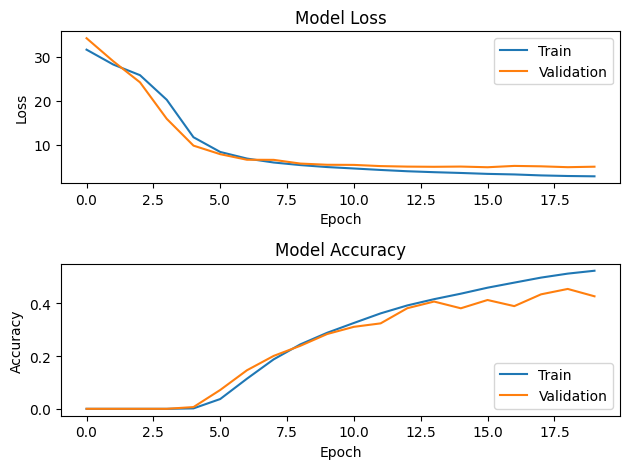

In [ ]:
# Plot training & validation loss values
plt.subplot(2, 1, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])  # Add validation loss plot
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

# Plot training & validation accuracy values
plt.subplot(2, 1, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])  # Add validation accuracy plot
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')

plt.tight_layout()
plt.show()


In [ ]:
# Save the trained model
act_model.save('/content/drive/MyDrive/bach/9010real.h5')


In [ ]:
def pre_process_image(path):

    img = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2GRAY)
    ### actually returns h, w
    h, w = img.shape

    ### if height less than 32
    if h < 32:
        add_zeros = np.ones((32-h, w)) * 255
        img = np.concatenate((img, add_zeros))
        h = 32

    ## if width less than 128
    if w < 128:
        add_zeros = np.ones((h, 128-w)) * 255
        img = np.concatenate((img, add_zeros), axis=1)
        w = 128

    ### if width is greater than 128 or height greater than 32
    if w > 128 or h > 32:
        img = cv2.resize(img, (128, 32))


    img = np.expand_dims(img , axis = 2)

    # Normalize each image
    img = img / 255.

    return img

In [ ]:
act_model.load_weights('/content/drive/MyDrive/bach/260.h5')

In [ ]:
def predict_output(img):
    # predict outputs on validation images
    prediction = act_model.predict(np.array([img]))
    ## shape (batch_size, num_timesteps, vocab_size)

    # use CTC decoder
    out = K.get_value(K.ctc_decode(prediction,
                                   input_length=np.ones(prediction.shape[0]) * prediction.shape[1],
                                   greedy=True)[0][0])

    ## get the final text
    for x in out:

        print("predicted text = ", end = '')

        for p in x:

            if int(p) != -1:
                print(char_list[int(p)], end = '')

        print('\n')

In [ ]:
from IPython.display import display
from random import randrange

for i in range(5):
    index = randrange(len(valid_final_paths))
    im = Image.open(valid_final_paths[index])
    display(im)

    print("\n")

    test_img = pre_process_image(valid_final_paths[index])
    predict_output(test_img)



1/1 [==============================] - 1s 961ms/step
predicted text = antbia





1/1 [==============================] - 0s 18ms/step
predicted text = Militarists





1/1 [==============================] - 0s 19ms/step
predicted text = airlines





1/1 [==============================] - 0s 19ms/step
predicted text = DOMICILEd





1/1 [==============================] - 0s 18ms/step
predicted text = gloomily



In [ ]:
from IPython.display import display
from random import randrange
test_img = pre_process_image('/content/502_I am Mohamed_85113.png')
predict_output(test_img)

1/1 [==============================] - 0s 67ms/step
predicted text = Tamhohaned



In [ ]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

<IPython.core.display.Javascript object>

Saved to photo.jpg


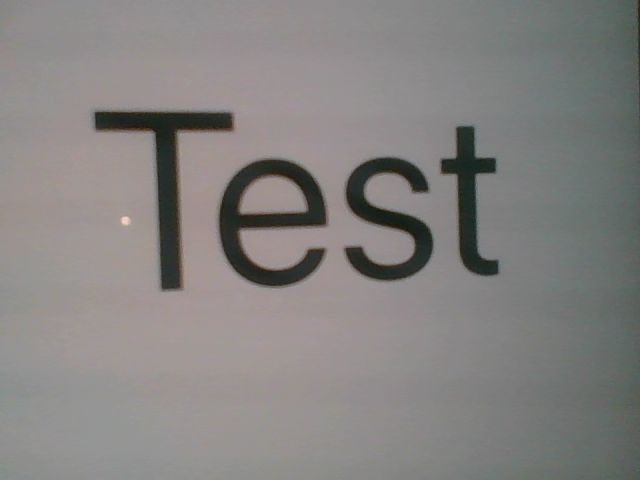

1/1 [==============================] - 0s 21ms/step
predicted text = Test



In [ ]:
from IPython.display import Image, display

try:
    filename = take_photo()
    print('Saved to {}'.format(filename))
    display(Image(filename))
    test_img = pre_process_image(filename)
    prediction = predict_output(test_img)
    if prediction is not None:
        print('Prediction: {}'.format(prediction))

except Exception as err:
    print(str(err))


In [ ]:
from IPython.display import display, Image, clear_output
import cv2
import pytesseract

# Load the image from file
image_path = 'path/to/your/image.jpg'
frame = cv2.imread(image_path)

# Use Tesseract OCR to extract text regions
text_regions = pytesseract.image_to_boxes(frame)

# Draw bounding boxes around text regions
for region in text_regions.splitlines():
    region = region.split()
    x, y, w, h = int(region[1]), int(region[2]), int(region[3]), int(region[4])
    cv2.rectangle(frame, (x, y), (w, h), (0, 255, 0), 2)

    # Crop the text region and preprocess for your model
    text_region_image = frame[y:h, x:w]
    preprocessed_image = pre_process_image(text_region_image)

    # Predict text using your model
    prediction = predict_text(preprocessed_image)

    # Display the prediction result if it is not None
    if prediction is not None:
        print(prediction)

# Display the image with bounding boxes
_, img_encoded = cv2.imencode('.png', frame)
display(Image(data=img_encoded.tobytes()))


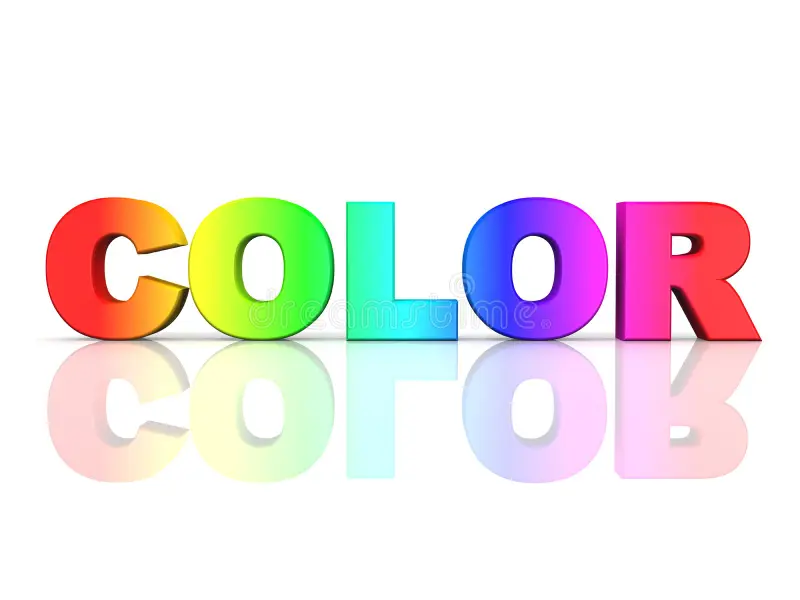

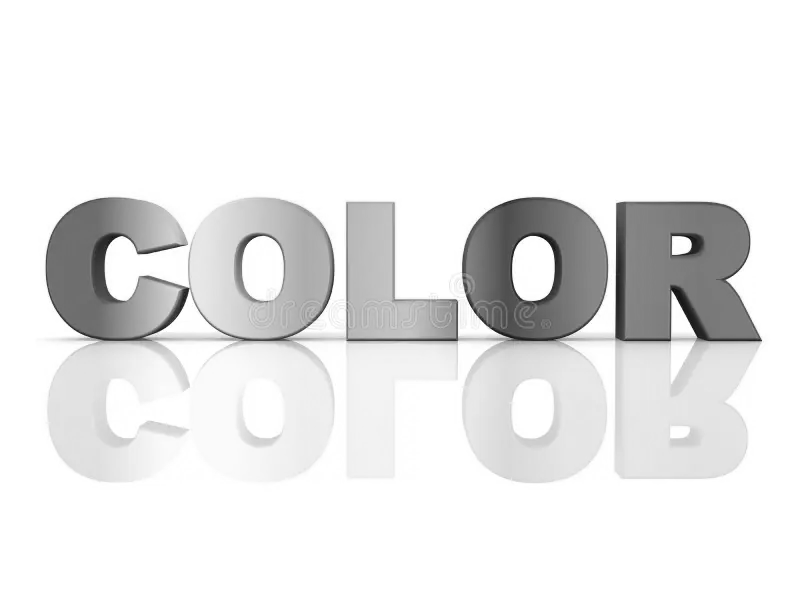

In [ ]:
import cv2
from google.colab import files
from IPython.display import Image, display

# Assuming you have the image file name
image_filename = "/content/copp.png"  # Replace with your actual image file name

# Read the uploaded image
image = cv2.imread(image_filename)

# Convert the image to grayscale
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Display the original and grayscale images
display(Image(filename=image_filename))
display(Image(data=cv2.imencode('.png', gray_image)[1].tobytes()))
